# Predictions statistics

Let's analyse the predictions made on our test datasplit.

**Note** To run this notebook you previously have to run and save the predictions on a test dataset **with ground-truth labels**. See the Datasplit section in [3.0 notebook](./3.0-Computing_predictions.ipynb#Predicting-a-datasplit-txt-file) for reference.


In [1]:
import os
import json
import numpy as np

from imgclas.data_utils import load_image
from imgclas import paths, plot_utils

import warnings
warnings.filterwarnings("ignore") # To ignore UndefinedMetricWarning: [Recall/Precision/F-Score] is ill-defined and being set to 0.0 in labels with no [true/predicted] samples.

# User parameters to set
TIMESTAMP = '2021-11-02_Lab_Madrid_CopasVasosAll_reg'       # timestamp of the model
# SPLIT_NAME = 'testLaRiojaICVVCopasAll'                   # dataset split to predict
SPLIT_NAME = 'test'
MODEL_NAME = 'final_model.h5'         # model to use to make the mediction

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME))
with open(pred_path) as f:
    pred_dict = json.load(f)

## Computing the metrics

Check [sklearn](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for more classification metrics.

In [2]:
from imgclas import test_utils
import sklearn.metrics as metrics
# https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b

y, yhat = np.array(pred_dict['true_value']), np.array(pred_dict['pred_value'])

mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y,yhat)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 8.014072530260073
MSE: 131.68075812343844
RMSE: 11.47522366332955
R-Squared: 0.9749452555862094


## Computing the confusion matrix

In [3]:
'''
Round a list of numbers to the closer 25th (i.e. 0, 25, 50, 75, etc.)

It is important to note that x.5 will be rounded to x instead of x+1 in the current 3.6.8 Python version.
For more details see https://stackoverflow.com/questions/10825926/python-3-x-rounding-behavior
'''

def myround_list(x, base=25):
    y=[]
    for i in x:
        y.append(round(base * round(float(i)/base)))
    return y

In [4]:
import matplotlib.pylab as plt
import seaborn
from sklearn.metrics import confusion_matrix


def plt_conf_matrix(conf_mat,  name, labels=False):
    
    fig = plt.figure(figsize=(20, 20))
    hm = seaborn.heatmap(conf_mat, annot=True, square=True, cbar_kws={'fraction':0.046, 'pad':0.04},
                         xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues, fmt=".2f")
    fontsize = None
    hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#     plt.savefig('/srv/image-results/'+name+'_confussionMatrix.jpg')

### Standard confusion matrix

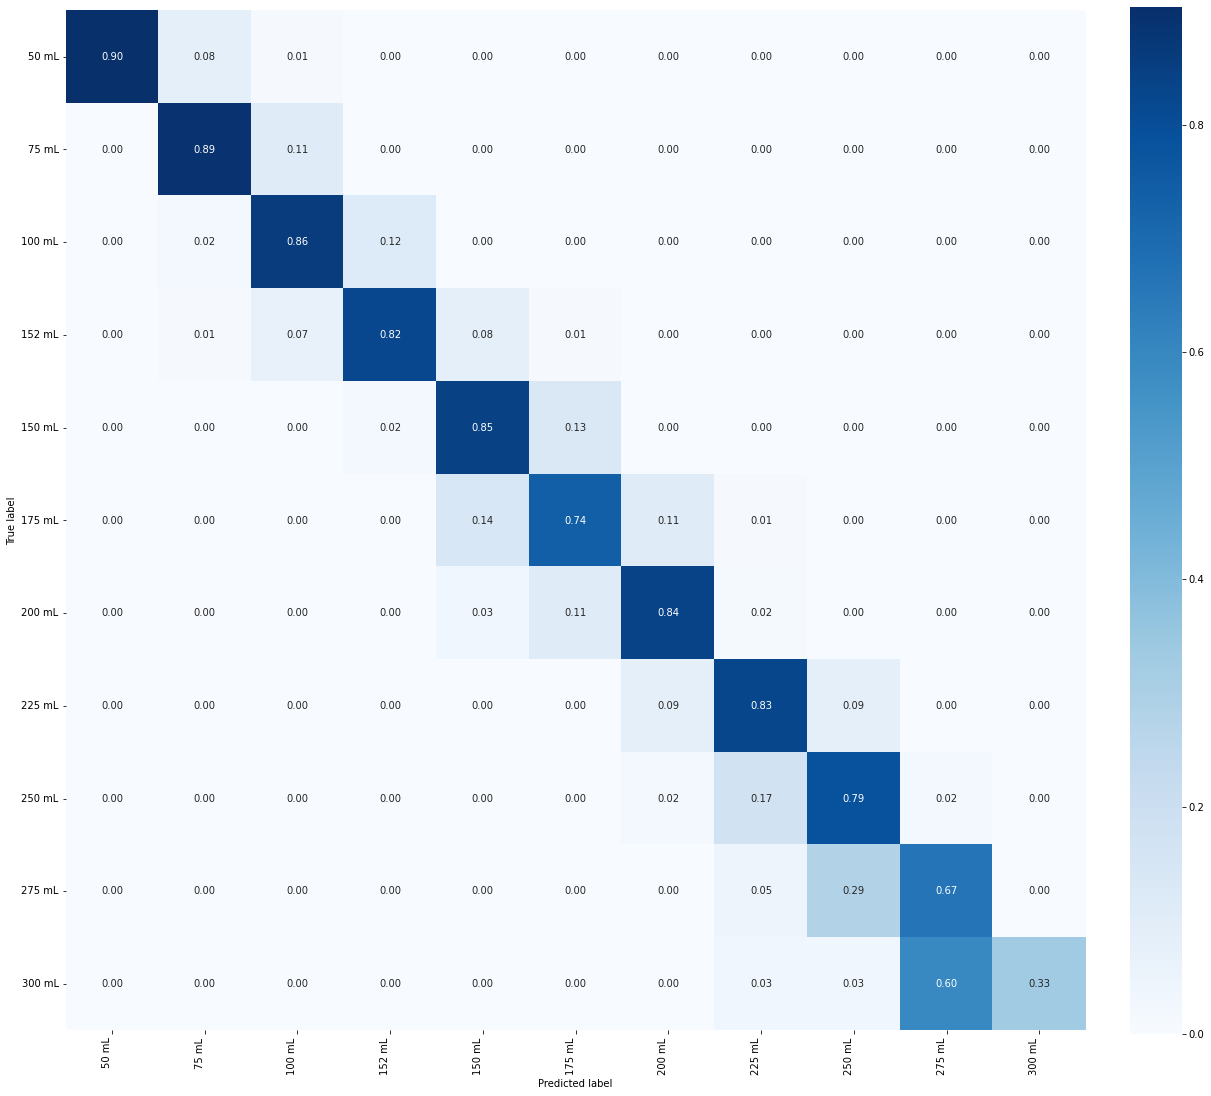

In [5]:
y_true, y_pred = np.array(pred_dict['true_value']), np.array(myround_list(pred_dict['pred_value']))
conf_mat = confusion_matrix(y_true, y_pred, sample_weight=None)
normed_conf = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]

# plt_conf_matrix(conf_mat)
plt_conf_matrix(normed_conf, labels=["50 mL", "75 mL", "100 mL", "152 mL", "150 mL",
                                    "175 mL", "200 mL", "225 mL", "250 mL", "275 mL",
                                    "300 mL"], name='Madrid_copasAll')

## Violin plots

In [6]:
import plotly.graph_objects as go

import pandas as pd

df = pd.DataFrame(data={'true_volume': pred_dict['true_value'], 'pred_volume': pred_dict['pred_value']})
# df = df.astype({"true_volume": type(pred_dict['pred_value'][0])})

fig = go.Figure()

volumes = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
# ['50', '75', '100', '125', '150', '175', '200', '225', '250', '275', '300']
for vol in volumes:
    fig.add_trace(go.Violin(x=df['true_volume'][df['true_volume'] == vol],
                            y=df['pred_volume'][df['true_volume'] == vol],
                            name=vol,
                            box_visible=True,
                            meanline_visible=True))
fig.update_traces(meanline_visible=True,
                  points='all', # show all points
                  jitter=0.05,  # add some jitter on points for better visibility
                  scalemode='count') #scale violin plot area with total count
fig.update_layout(
    title_text="Predicted volumes distribution")
    
fig.write_image("/srv/image-results/violin_plot.png")

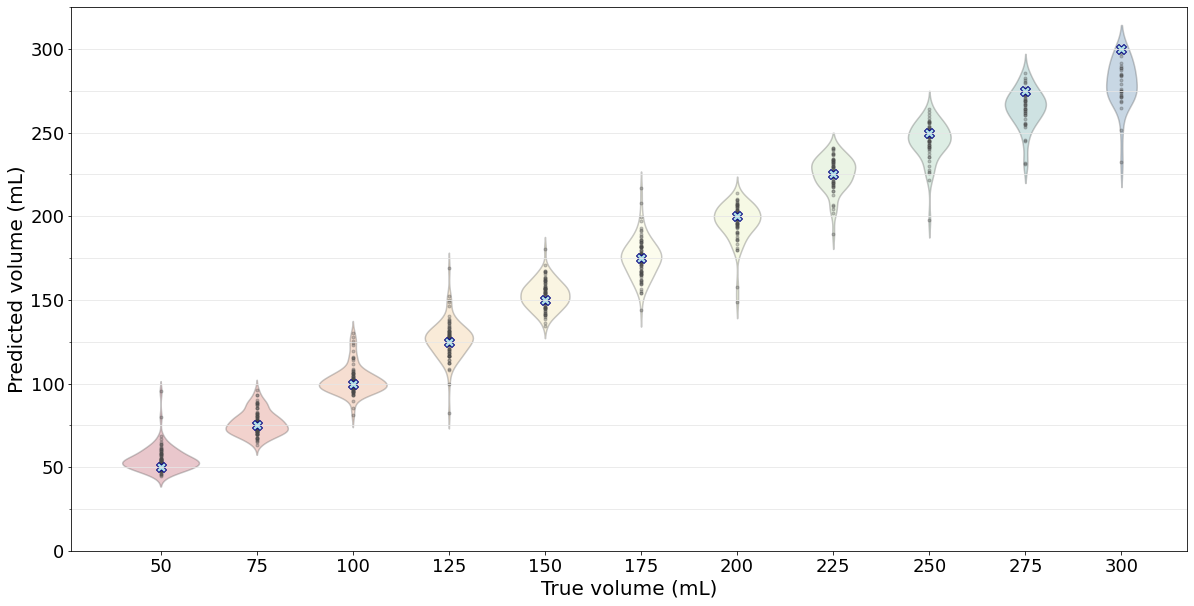

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.rcParams["figure.figsize"] = (20,10)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

sns.set_theme()
sns.set_style(style='white') 

ax = sns.violinplot(x='true_volume', y='pred_volume', data=df, inner="points",
                    palette="Spectral")
ax.set(xlabel='True volume (mL)', ylabel='Predicted volume (mL)')
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
# sns.boxplot(x='true_volume', y='pred_volume', data=df, palette='rainbow', width=0.3,
#             boxprops={'zorder': 2}, ax=ax)
# plt.title("Predicted volumes distribution", fontsize=22)
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(25))
plt.grid(axis='y', which='both', color='0.9')
# for v in volumes:
#     xrange = np.arange(0, v)
#     plt.plot(xrange, np.ones(xrange.shape) * v)
plt.ylim([0, 325])
plt.setp(ax.collections, alpha=.3)
plt.scatter(x=range(len(volumes)),y=volumes, c="powderblue",  
            marker='X', s=100, edgecolor='navy')
plt.savefig('/srv/image-results/violin_plot_general.pdf',bbox_inches='tight')
plt.show()

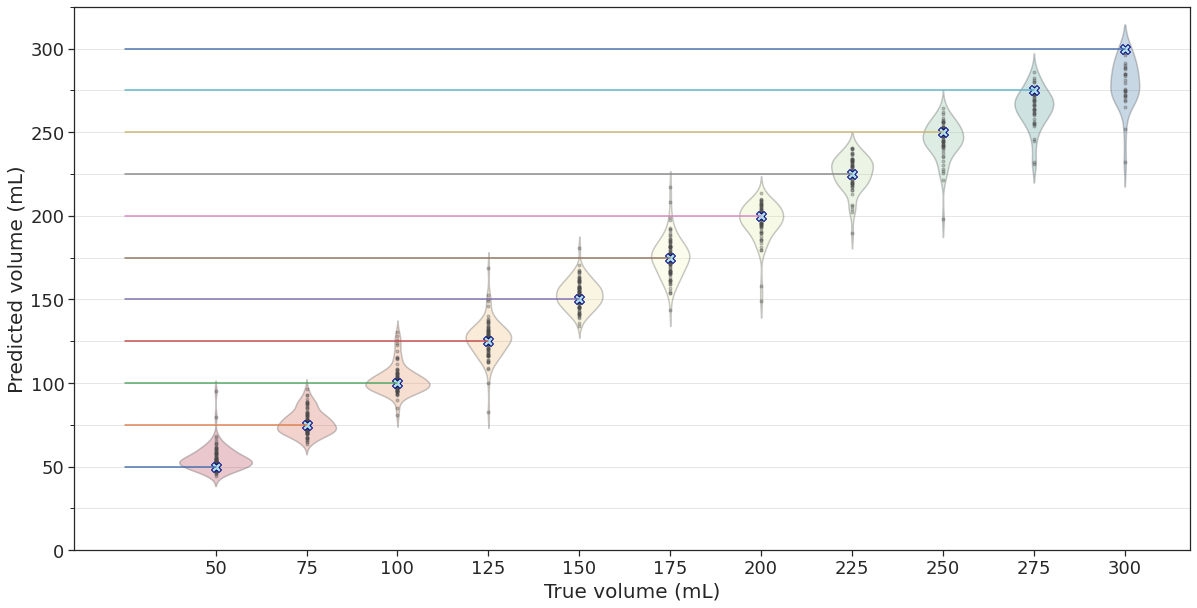

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.rcParams["figure.figsize"] = (20,10)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

sns.set_theme()
sns.set_style(style='white') 

ax = sns.violinplot(x='true_volume', y='pred_volume', data=df, inner="points",
                    palette="Spectral")
ax.set(xlabel='True volume (mL)', ylabel='Predicted volume (mL)')
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
# sns.boxplot(x='true_volume', y='pred_volume', data=df, palette='rainbow', width=0.3,
#             boxprops={'zorder': 2}, ax=ax)
# plt.title("Predicted volumes distribution", fontsize=22)
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(25))
plt.grid(axis='y', which='both', color='0.9')
for i, v in enumerate(volumes):
    xrange = np.linspace(-1, i, 100)
    ax.plot(xrange, [v]*len(xrange))
plt.ylim([0, 325])
plt.setp(ax.collections, alpha=.3)
plt.scatter(x=range(len(volumes)),y=volumes, c="powderblue",  
            marker='X', s=100, edgecolor='navy')
# plt.savefig('/srv/image-results/violin_plot_general.pdf',bbox_inches='tight')
plt.show()

In [9]:
# https://matplotlib.org/stable/gallery/color/named_colors.html colors in matplotlib

In [10]:
type(df.true_volume.astype(np.float64))

pandas.core.series.Series

In [11]:
df.true_volume[0]

100

In [12]:
type(np.array(volumes).astype(np.int64))

numpy.ndarray

In [13]:
type(volumes[0])

int

In [14]:
# https://stackabuse.com/seaborn-violin-plot-tutorial-and-examples/ interesante sobre
# violin plots
# https://www.linuxtut.com/en/c79c9973a92e1e2c77a7/ # seaborn palletes